In [ ]:
import dill
dill.load_session('.db')

In [1]:
import pandas as pd 

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [3]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
from sklearn.ensemble import GradientBoostingClassifier


In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss

In [5]:
path = 'C:/Users/isaac/Dropbox/Apps/ShareLaTeX/Donde2020'

In [29]:
# Read data 
data = pd.read_csv(path + '/_aux/data_oc.csv') 
data.head()



,prenda,val_pren,genero,edad,pres_antes,ahorros,cta_tanda,rec_cel,prestamo,des_c,...,dummy_prenda_tipo2,dummy_prenda_tipo3,dummy_prenda_tipo4,dummy_prenda_tipo5,dummy_educacion2,dummy_educacion3,dummy_educacion4,dummy_educacion5,dummy_plan_gasto2,dummy_plan_gasto3
0,78133041,1895.252563,1,47.0,1,0,0,0,1200,0,...,1,0,0,0,0,1,0,0,0,0
1,5521269,5566.590820,1,50.0,1,0,0,0,3440,1,...,0,0,0,1,0,1,0,0,1,0
2,5521268,7710.254883,1,50.0,1,0,0,0,4780,1,...,0,0,0,1,0,1,0,0,1,0
3,5521267,2351.094727,1,50.0,1,0,0,0,1430,1,...,0,0,0,1,0,1,0,0,1,0
4,42124669,3780.000000,1,50.0,1,0,0,1,1260,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
# Distinguish numerical variables
numeric_features = ['val_pren', 'edad',  'prestamo',  'faltas']

categorical_features = ['genero',
            'pres_antes',
            'ahorros',
            'cta_tanda',
            'rec_cel',
            'tentado',
            'dummy_prenda_tipo2',
            'dummy_prenda_tipo3',
            'dummy_prenda_tipo4',
            'dummy_prenda_tipo5',
            'dummy_educacion2',
            'dummy_educacion3',
            'dummy_educacion4',
            'dummy_educacion5',
            'dummy_plan_gasto2',
            'dummy_plan_gasto3']

# Pre-processing of numerical variables 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('polynomial', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse = False)


# First step of Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
X = data[['val_pren', 'edad',  'prestamo',  'faltas', 'genero',
            'pres_antes',
            'ahorros',
            'cta_tanda',
            'rec_cel',
            'tentado',
            'dummy_prenda_tipo2',
            'dummy_prenda_tipo3',
            'dummy_prenda_tipo4',
            'dummy_prenda_tipo5',
            'dummy_educacion2',
            'dummy_educacion3',
            'dummy_educacion4',
            'dummy_educacion5',
            'dummy_plan_gasto2',
            'dummy_plan_gasto3']]

y = data['des_c']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
# Hyperparameters - grid
# ==============================================================================
param_grid = {'model__n_neighbors'  : [2, 3, 4, 5, 6],
              'model__weights'     : ['uniform', 'distance'],
              'model__algorithm'     : ['auto', 'ball_tree', 'kd_tree', 'brute']
             }


knn_est = KNeighborsClassifier(
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None)

# KNN Model
KNN = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', knn_est)])


# Grid search by cross-validation
# ==============================================================================
grid = GridSearchCV(KNN,
        param_grid = param_grid,
        scoring    = 'f1_weighted',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_model__algorithm,param_model__n_neighbors,param_model__weights,mean_test_score,std_test_score,mean_train_score,std_train_score
39,brute,6,distance,0.619211,0.010494,1.0,0.0
29,kd_tree,6,distance,0.619211,0.010494,1.0,0.0
19,ball_tree,6,distance,0.619211,0.010494,1.0,0.0
9,auto,6,distance,0.619211,0.010494,1.0,0.0


In [10]:
# Recover the best model
final_model_knn = grid.best_estimator_

In [11]:
from sklearn.tree import DecisionTreeClassifier
# Hyperparameters - grid
# ==============================================================================
param_grid = {'model__max_depth'  : [2, 3, 4, 5, 6, 7, 8, 10, 20, 50]
             }


dt_est = DecisionTreeClassifier(criterion="entropy")

# DT Model
DT = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', dt_est)])


# Grid search by cross-validation
# ==============================================================================
grid = GridSearchCV(DT,
        param_grid = param_grid,
        scoring    = 'f1_weighted',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_model__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
9,50,0.550285,0.008763,1.000000,0.000000
8,20,0.542398,0.002754,0.896340,0.035690
7,10,0.531921,0.018136,0.690300,0.034709
5,7,0.529670,0.024306,0.622494,0.033702


In [12]:
# Recover the best model
final_model_dt = grid.best_estimator_

In [13]:
from sklearn import svm
# Hyperparameters - grid
# ==============================================================================
param_grid = {'model__kernel': ['poly', 'rbf', 'sigmoid', 'precomputed'],
              'model__C'     : [0.01, 0.1, 0.2, 0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9, 1]
             }


svm_est = svm.SVC()

# SVM Model
SVM = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', svm_est)])


# Grid search by cross-validation
# ==============================================================================
grid = GridSearchCV(SVM,
        param_grid = param_grid,
        scoring    = 'f1_weighted',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.40408076 0.39584984 0.39584984        nan 0.44758221 0.45828939
 0.52031574        nan 0.45707716 0.48520606 0.52926188        nan
 0.4696991  0.49418074 0.52509432        nan 0.479531   0.50241944
 0.52923396        nan 0.48429473 0.50843824 0.52601479        nan
 0.48869851 0.51241128 0.52694585        nan 0.49398906 0.51605127
 0.52690194        nan 0.49508735 0.52453963 0.52146373        nan
 0.50065746 0.53051043 0.52104156        nan 0.5031104  0.53366102
 0.52198851        nan]
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.41335902 0.39581785 0.39581785        nan 0.46414898 0.47014385
 0.5222745         nan 0.48075684 0.50402739 0.51643364        nan
 0.49166508 0.51771431 0.51933002        nan 0.50341873 0.52578027
 0

,param_model__C,param_model__kernel,mean_test_score,std_test_score,mean_train_score,std_train_score
41,1,rbf,0.533661,0.027531,0.568197,0.005540
37,0.9,rbf,0.530510,0.026682,0.559254,0.003440
10,0.2,sigmoid,0.529262,0.018166,0.516434,0.010005
18,0.4,sigmoid,0.529234,0.015489,0.524914,0.013745


In [14]:
# Recover the best model
final_model_svm = grid.best_estimator_

In [15]:
from sklearn.linear_model import LogisticRegression
# Hyperparameters - grid
# ==============================================================================
param_grid = {'model__penalty'  : ['l1', 'l2', 'elasticnet'],
              'model__C'     : [0.0001, 0.001, 0.01, 0.1, 1, 10, 20]
             }


logit_est = LogisticRegression(random_state = 0,
                              max_iter = 10000)

# Logit Model
LOGIT = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', logit_est)])


# Grid search by cross-validation
# ==============================================================================
grid = GridSearchCV(LOGIT,
        param_grid = param_grid,
        scoring    = 'f1_weighted',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.40471605        nan        nan 0.50031809        nan
        nan 0.53876687        nan        nan 0.54096457        nan
        nan 0.54381484        nan        nan 0.5411435         nan
        nan 0.54078586        nan]
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 0.40755465        nan        nan 0.50604705        nan
        nan 0.54516609        nan        nan 0.54962339        nan
        nan 0.55634793        nan        nan 0.56022979        nan
        nan 0.55918139        nan]
  warnings.warn(


,param_model__C,param_model__penalty,mean_test_score,std_test_score,mean_train_score,std_train_score
13,1,l2,0.543815,0.012443,0.556348,0.007073
16,10,l2,0.541144,0.004759,0.560230,0.009690
10,0.1,l2,0.540965,0.013866,0.549623,0.002449
19,20,l2,0.540786,0.004234,0.559181,0.009076


In [16]:
# Recover the best model
final_model_logit = grid.best_estimator_

In [17]:
from catboost import CatBoostClassifier, Pool

In [18]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'model__iterations'  : [500, 1000, 1500],
              'model__depth'     : [3, 5, 6, 10, 20],
              'model__learning_rate' : [0.0005, 0.001, 0.01, 0.1]
             }


CBC = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', CatBoostClassifier(random_state=123))])


# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = CBC,
        param_grid = param_grid,
        scoring    = 'f1_weighted',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.48714724 0.48944678 0.51778418 0.56456665 0.48972944 0.49360866
 0.541541   0.56446792 0.4915914  0.49620482 0.54853547 0.5615992
 0.49949786 0.50151978 0.5488411  0.56891366 0.49885888 0.50180854
 0.55329712 0.56904237 0.49979199 0.50416677 0.55716087 0.57706811
 0.50168334 0.50555698 0.54960105 0.57776659 0.50586389 0.50797854
 0.56061933 0.57536022 0.5066252  0.51778188 0.56698695 0.57696559
 0.54992597 0.55168801 0.58568106 0.59715994 0.55258286 0.56126184
 0.59230212 0.59254296 0.55773197 0.5686589  0.59435011 0.59213659
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.49805955 0.50043834 0.5

0:	learn: 0.6821235	total: 422ms	remaining: 3m 30s
1:	learn: 0.6677906	total: 695ms	remaining: 2m 53s
2:	learn: 0.6537527	total: 985ms	remaining: 2m 43s
3:	learn: 0.6470815	total: 1.25s	remaining: 2m 35s
4:	learn: 0.6401002	total: 1.6s	remaining: 2m 38s
5:	learn: 0.6303299	total: 1.87s	remaining: 2m 34s
6:	learn: 0.6231334	total: 2.13s	remaining: 2m 30s
7:	learn: 0.6148067	total: 2.38s	remaining: 2m 26s
8:	learn: 0.6058666	total: 2.69s	remaining: 2m 26s
9:	learn: 0.5951090	total: 2.98s	remaining: 2m 25s
10:	learn: 0.5922606	total: 3.25s	remaining: 2m 24s
11:	learn: 0.5851274	total: 3.53s	remaining: 2m 23s
12:	learn: 0.5820496	total: 3.79s	remaining: 2m 21s
13:	learn: 0.5773835	total: 4.08s	remaining: 2m 21s
14:	learn: 0.5723414	total: 4.37s	remaining: 2m 21s
15:	learn: 0.5667039	total: 4.7s	remaining: 2m 22s
16:	learn: 0.5591125	total: 4.97s	remaining: 2m 21s
17:	learn: 0.5538084	total: 5.25s	remaining: 2m 20s
18:	learn: 0.5517967	total: 5.57s	remaining: 2m 20s
19:	learn: 0.5492412	tot

158:	learn: 0.2638876	total: 45.8s	remaining: 1m 38s
159:	learn: 0.2627658	total: 46.1s	remaining: 1m 37s
160:	learn: 0.2615277	total: 46.4s	remaining: 1m 37s
161:	learn: 0.2599443	total: 46.7s	remaining: 1m 37s
162:	learn: 0.2583400	total: 47s	remaining: 1m 37s
163:	learn: 0.2579596	total: 47.3s	remaining: 1m 36s
164:	learn: 0.2567733	total: 47.6s	remaining: 1m 36s
165:	learn: 0.2553567	total: 47.9s	remaining: 1m 36s
166:	learn: 0.2548102	total: 48.2s	remaining: 1m 36s
167:	learn: 0.2536932	total: 48.5s	remaining: 1m 35s
168:	learn: 0.2517863	total: 48.8s	remaining: 1m 35s
169:	learn: 0.2500416	total: 49.1s	remaining: 1m 35s
170:	learn: 0.2496646	total: 49.4s	remaining: 1m 35s
171:	learn: 0.2493633	total: 49.7s	remaining: 1m 34s
172:	learn: 0.2470389	total: 50s	remaining: 1m 34s
173:	learn: 0.2460360	total: 50.4s	remaining: 1m 34s
174:	learn: 0.2447864	total: 50.6s	remaining: 1m 34s
175:	learn: 0.2431603	total: 50.9s	remaining: 1m 33s
176:	learn: 0.2423083	total: 51.2s	remaining: 1m 3

313:	learn: 0.1401654	total: 1m 31s	remaining: 54.1s
314:	learn: 0.1400155	total: 1m 31s	remaining: 53.8s
315:	learn: 0.1393280	total: 1m 31s	remaining: 53.5s
316:	learn: 0.1386488	total: 1m 32s	remaining: 53.2s
317:	learn: 0.1378516	total: 1m 32s	remaining: 53s
318:	learn: 0.1375302	total: 1m 32s	remaining: 52.7s
319:	learn: 0.1367554	total: 1m 33s	remaining: 52.4s
320:	learn: 0.1362086	total: 1m 33s	remaining: 52.1s
321:	learn: 0.1358255	total: 1m 33s	remaining: 51.8s
322:	learn: 0.1354790	total: 1m 34s	remaining: 51.5s
323:	learn: 0.1352131	total: 1m 34s	remaining: 51.2s
324:	learn: 0.1346924	total: 1m 34s	remaining: 50.9s
325:	learn: 0.1341660	total: 1m 34s	remaining: 50.7s
326:	learn: 0.1331971	total: 1m 35s	remaining: 50.4s
327:	learn: 0.1327841	total: 1m 35s	remaining: 50.2s
328:	learn: 0.1322894	total: 1m 35s	remaining: 49.9s
329:	learn: 0.1320278	total: 1m 36s	remaining: 49.6s
330:	learn: 0.1314698	total: 1m 36s	remaining: 49.4s
331:	learn: 0.1311890	total: 1m 36s	remaining: 4

469:	learn: 0.0851801	total: 2m 19s	remaining: 8.92s
470:	learn: 0.0851152	total: 2m 20s	remaining: 8.62s
471:	learn: 0.0848627	total: 2m 20s	remaining: 8.33s
472:	learn: 0.0845996	total: 2m 20s	remaining: 8.03s
473:	learn: 0.0841132	total: 2m 20s	remaining: 7.73s
474:	learn: 0.0839462	total: 2m 21s	remaining: 7.44s
475:	learn: 0.0836746	total: 2m 21s	remaining: 7.14s
476:	learn: 0.0834553	total: 2m 21s	remaining: 6.84s
477:	learn: 0.0831155	total: 2m 22s	remaining: 6.54s
478:	learn: 0.0828676	total: 2m 22s	remaining: 6.25s
479:	learn: 0.0824723	total: 2m 22s	remaining: 5.95s
480:	learn: 0.0820589	total: 2m 23s	remaining: 5.65s
481:	learn: 0.0818180	total: 2m 23s	remaining: 5.35s
482:	learn: 0.0816206	total: 2m 23s	remaining: 5.05s
483:	learn: 0.0814453	total: 2m 23s	remaining: 4.75s
484:	learn: 0.0811688	total: 2m 24s	remaining: 4.46s
485:	learn: 0.0807410	total: 2m 24s	remaining: 4.16s
486:	learn: 0.0802995	total: 2m 24s	remaining: 3.86s
487:	learn: 0.0798400	total: 2m 24s	remaining:

,param_model__depth,param_model__iterations,param_model__learning_rate,mean_test_score,std_test_score,mean_train_score,std_train_score
39,10,500,0.1,0.597160,0.006452,1.000000,0.000000
46,10,1500,0.01,0.594350,0.007996,0.995534,0.001202
43,10,1000,0.1,0.592543,0.009479,1.000000,0.000000
42,10,1000,0.01,0.592302,0.006627,0.979460,0.002821


In [19]:
final_model_cbc = grid.best_estimator_

In [20]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'model__n_estimators'  : [50, 100, 500, 1000],
              'model__max_features'  : ['auto', 'sqrt', 'log2'],
              'model__max_depth'     : [None, 1, 3, 5, 10, 20],
              'model__subsample'     : [0.5, 1],
              'model__learning_rate' : [0.001, 0.01, 0.1]
             }


GBC = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', GradientBoostingClassifier(random_state=123))])


# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = GBC,
        param_grid = param_grid,
        scoring    = 'f1_weighted',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_model__learning_rate,param_model__max_depth,param_model__max_features,param_model__n_estimators,param_model__subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
425,0.1,20,log2,50,1,0.593860,0.004625,1.0,0.0
427,0.1,20,log2,100,1,0.593649,0.003115,1.0,0.0
285,0.01,20,log2,500,1,0.592105,0.003821,1.0,0.0
419,0.1,20,sqrt,100,1,0.592053,0.001673,1.0,0.0


In [21]:
final_model_gbc = grid.best_estimator_

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'model__n_estimators': [150, 200],
              'model__max_features': [5, 7, 9],
              'model__max_depth'   : [None, 3, 10, 20],
              'model__criterion'   : ['gini', 'entropy']
             }



RFC = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', RandomForestClassifier(random_state=123))])


# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RFC,
        param_grid = param_grid,
        scoring    = 'f1_weighted',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_model__criterion,param_model__max_depth,param_model__max_features,param_model__n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
25,entropy,None,5,200,0.582002,0.019135,1.000000,0.000000
43,entropy,20,5,200,0.581523,0.021385,0.999977,0.000087
1,gini,None,5,200,0.580900,0.018971,1.000000,0.000000
27,entropy,None,7,200,0.580507,0.019149,1.000000,0.000000


In [24]:
final_model_rfc = grid.best_estimator_

In [25]:
#Metric Results


metric_results_oos = pd.DataFrame({'KNN' :  [accuracy_score(y_test, final_model_knn.predict(X_test)),
    f1_score(y_test, final_model_knn.predict(X_test), average = 'weighted'),
    jaccard_score(y_test, final_model_knn.predict(X_test), average = 'weighted'),
    log_loss(y_test, final_model_knn.predict(X_test))],
                                     'Decision Tree' :  [accuracy_score(y_test, final_model_dt.predict(X_test)),
    f1_score(y_test, final_model_dt.predict(X_test), average = 'weighted'),
    jaccard_score(y_test, final_model_dt.predict(X_test), average = 'weighted'),
    log_loss(y_test, final_model_dt.predict(X_test))], 
                                     'SVM' :  [accuracy_score(y_test, final_model_svm.predict(X_test)),
    f1_score(y_test, final_model_svm.predict(X_test), average = 'weighted'),
    jaccard_score(y_test, final_model_svm.predict(X_test), average = 'weighted'),
    log_loss(y_test, final_model_svm.predict(X_test))],
                                     'Logit' :  [accuracy_score(y_test, final_model_logit.predict(X_test)),
    f1_score(y_test, final_model_logit.predict(X_test), average = 'weighted'),
    jaccard_score(y_test, final_model_logit.predict(X_test), average = 'weighted'),
    log_loss(y_test, final_model_logit.predict(X_test))],
                                    'GBC' :  [accuracy_score(y_test, final_model_gbc.predict(X_test)),
    f1_score(y_test, final_model_gbc.predict(X_test), average = 'weighted'),
    jaccard_score(y_test, final_model_gbc.predict(X_test), average = 'weighted'),
    log_loss(y_test, final_model_gbc.predict(X_test))],
                                    'CBC' :  [accuracy_score(y_test, final_model_cbc.predict(X_test)),
    f1_score(y_test, final_model_cbc.predict(X_test), average = 'weighted'),
    jaccard_score(y_test, final_model_cbc.predict(X_test), average = 'weighted'),
    log_loss(y_test, final_model_cbc.predict(X_test))],
                                    'RF' :  [accuracy_score(y_test, final_model_rfc.predict(X_test)),
    f1_score(y_test, final_model_rfc.predict(X_test), average = 'weighted'),
    jaccard_score(y_test, final_model_rfc.predict(X_test), average = 'weighted'),
    log_loss(y_test, final_model_rfc.predict(X_test))]                               
                        })
     
     
# Change the row indexes
metric_results_oos.index = ['Accuracy', 'F1', 'Jaccard', 'Log-loss']


metric_results_oos

,KNN,Decision Tree,SVM,Logit,GBC,CBC,RF
Accuracy,0.605351,0.520624,0.552954,0.541806,0.556299,0.590858,0.583055
F1,0.600887,0.520376,0.485160,0.504828,0.548478,0.586334,0.572496
Jaccard,0.431987,0.352538,0.345262,0.352022,0.381799,0.417335,0.405916
Log-loss,13.630815,16.557239,15.440461,15.825548,15.325035,14.131383,14.400900


In [26]:
metric_results_ins = pd.DataFrame({'KNN' :  [accuracy_score(y_train, final_model_knn.predict(X_train)),
    f1_score(y_train, final_model_knn.predict(X_train), average = 'weighted'),
    jaccard_score(y_train, final_model_knn.predict(X_train), average = 'weighted'),
    log_loss(y_train, final_model_knn.predict(X_train))],
                                     'Decision Tree' :  [accuracy_score(y_train, final_model_dt.predict(X_train)),
    f1_score(y_train, final_model_dt.predict(X_train), average = 'weighted'),
    jaccard_score(y_train, final_model_dt.predict(X_train), average = 'weighted'),
    log_loss(y_train, final_model_dt.predict(X_train))], 
                                     'SVM' :  [accuracy_score(y_train, final_model_svm.predict(X_train)),
    f1_score(y_train, final_model_svm.predict(X_train), average = 'weighted'),
    jaccard_score(y_train, final_model_svm.predict(X_train), average = 'weighted'),
    log_loss(y_train, final_model_svm.predict(X_train))],
                                     'Logit' :  [accuracy_score(y_train, final_model_logit.predict(X_train)),
    f1_score(y_train, final_model_logit.predict(X_train), average = 'weighted'),
    jaccard_score(y_train, final_model_logit.predict(X_train), average = 'weighted'),
    log_loss(y_train, final_model_logit.predict(X_train))],
                                     'GBC' :  [accuracy_score(y_train, final_model_gbc.predict(X_train)),
    f1_score(y_train, final_model_gbc.predict(X_train), average = 'weighted'),
    jaccard_score(y_train, final_model_gbc.predict(X_train), average = 'weighted'),
    log_loss(y_train, final_model_gbc.predict(X_train))],
                                     'CBC' :  [accuracy_score(y_train, final_model_cbc.predict(X_train)),
    f1_score(y_train, final_model_cbc.predict(X_train), average = 'weighted'),
    jaccard_score(y_train, final_model_cbc.predict(X_train), average = 'weighted'),
    log_loss(y_train, final_model_cbc.predict(X_train))],
                                     'RF' :  [accuracy_score(y_train, final_model_rfc.predict(X_train)),
    f1_score(y_train, final_model_rfc.predict(X_train), average = 'weighted'),
    jaccard_score(y_train, final_model_rfc.predict(X_train), average = 'weighted'),
    log_loss(y_train, final_model_rfc.predict(X_train))]                               
                        })
     
# Change the row indexes
metric_results_ins.index = ['Accuracy', 'F1', 'Jaccard', 'Log-loss']


metric_results_ins

,KNN,Decision Tree,SVM,Logit,GBC,CBC,RF
Accuracy,1.000000e+00,1.000000e+00,0.625279,0.588728,1.000000e+00,1.000000e+00,1.000000e+00
F1,1.000000e+00,1.000000e+00,0.568329,0.557911,1.000000e+00,1.000000e+00,1.000000e+00
Jaccard,1.000000e+00,1.000000e+00,0.420265,0.400847,1.000000e+00,1.000000e+00,1.000000e+00
Log-loss,9.992007e-16,9.992007e-16,12.942432,14.204923,9.992007e-16,9.992007e-16,9.992007e-16


In [27]:
import dill
dill.dump_session('oc_prediction_session.db')

In [27]:
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report

In [73]:
params = final_model_knn.get_params()
params


{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('polynomial',
                                                     PolynomialFeatures(degree=3,
                                                                        include_bias=False)),
                                                    ('scaler', StandardScaler())]),
                                    ['val_pren', 'edad', 'prestamo', 'faltas']),
                                   ('cat',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['genero', 'pres_antes', 'ahorros',
                                     'cta_tanda', 'rec_cel', 'tentado',
                         

In [36]:
KNN.set_params(**params)
KNN.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['val_pren', 'edad',
                                                   'prestamo', 'faltas']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknow

In [74]:
print('accuracy :', accuracy_score(y,  KNN.predict(X)))

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [40]:
predicciones  = KNN.predict_proba(X = X_test)
predicciones
prob_positivo = predicciones[:, 1]

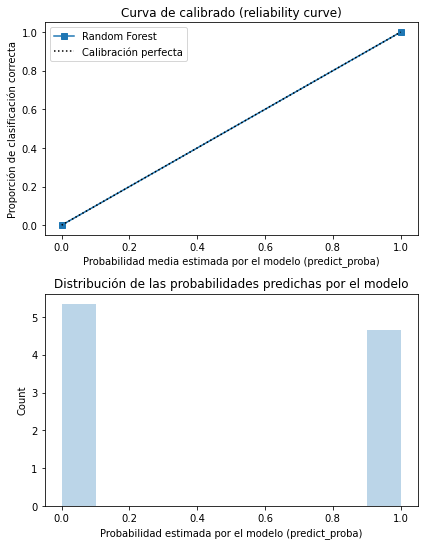

In [42]:
import matplotlib.pyplot as plt
fraccion_positivos, media_prob_predicha = calibration_curve(y_test, prob_positivo, n_bins=20)
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))

axs[0].plot(media_prob_predicha, fraccion_positivos, "s-", label="Random Forest")
axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
axs[0].set_ylabel("Proporción de clasificación correcta")
axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
axs[0].set_title('Curva de calibrado (reliability curve)')
axs[0].legend()

axs[1].hist(prob_positivo, range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribución de las probabilidades predichas por el modelo')

plt.tight_layout()
plt.show();

In [ ]:
df_pred = pd.read_csv(path + '/_aux/oc_data.csv') 
pred = df_pred[['val_pren', 'edad',  'prestamo',  'faltas', 'genero',
            'pres_antes',
            'ahorros',
            'cta_tanda',
            'rec_cel',
            'tentado',
            'dummy_prenda_tipo2',
            'dummy_prenda_tipo3',
            'dummy_prenda_tipo4',
            'dummy_prenda_tipo5',
            'dummy_educacion2',
            'dummy_educacion3',
            'dummy_educacion4',
            'dummy_educacion5',
            'dummy_plan_gasto2',
            'dummy_plan_gasto3']]

dict_classifiers = {
    "Logit": [final_model_logit, LOGIT],
    "SVM": [final_model_svm, SVM],
    "KNN": [final_model_knn, KNN],
    "GBC": [final_model_gbc, GBC],
    "DT": [final_model_dt, DT],
    "CBC": [final_model_cbc, CBC],
    "RF": [final_model_rfc, RFC]
}


In [ ]:

repay = df_pred[['des_c']]

for model in dict_classifiers:
    params = dict_classifiers[model][0].get_params()
    dict_classifiers[model][1].set_params(**params)
    dict_classifiers[model][1].fit(X,y)
    print(model,'accuracy :', accuracy_score(y,  dict_classifiers[model][1].predict(X)))
    dta = pd.DataFrame(dict_classifiers[model][1].predict_proba(pred))
    name0 = 'pr_'+model+'_0'
    name1 = 'pr_'+model+'_1'    
    dta.rename(columns={0: name0, 1: name1}, inplace=True)
    pre = pd.DataFrame(dict_classifiers[model][1].predict(pred))
    name = 'pre_'+model
    pre.rename(columns={0: name}, inplace=True)
    repay = pd.concat([repay, dta, pre], axis=1)

In [ ]:
repay

In [ ]:
import os
repay.to_csv(os.path.join(path + '/_aux/repay_pred.csv') , index = False)


In [ ]:
importancia = permutation_importance(
                estimator    = GBC,
                X            = X,
                y            = y,
                n_repeats    = 5,
                scoring      = 'f1_weighted',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

In [ ]:
import matplotlib.pyplot as plt
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');